<a href="https://colab.research.google.com/github/tsarthak/ecegy6143-proximal-policy-optimization/blob/main/PPO_Intro_ML_Fall_22_Course_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimization

---

| Name           | Net ID |
|----------------|--------|
| Sarthak Tickoo | st4035 |


## Introduction

---

The core objective of this project is understand what Proximal Policy Optimization ([PPO](#ppo)) algorithm is, and what does it improve over other algorithms and verify/ validate some claims.

### A brief and naive refresher on types of learning algorithms

- Reinforcement learning algorithms, like supervised and unsupervised learning algorithms are types of machine learning algorithms. Supervised and Unsupervised algorithms rely on some form of priori samples with enumerable features, which we try to understand or _learn_ some "patterns" from, in order to predict or estimate possible outcome(s) as $\hat{\mathbf{y}} = f(\mathbf{X}, \cdot)$ where $\mathbf{X} \in \mathbb{R}^{m \times n} \ , \ \mathbf{y} \in \mathbb{R}^{m \times 1}$. This mapping can be further parameterized based on the type of feature mapping or other learning parameters.
- These outcomes could be classes (mapped to a finite discrete value space), or in the form of a computable continuous value $\in \mathbb{R}$.
- The major distinction between the three techniques is the kind of data they learn with (labelled or unlabelled), or whether they learn as they gather data.
- _Supervised Learning algorithms_ (like Linear Regression, K-Nearest Neighbours etc.) typically use _labels_ i.e. a guide to self-check if the value that we predict actually matches with the real world value or not in the form of performance metrics like accuracy and MSE.
- _Unsupervised learning algorithms_ (like K-Means Clustering, PCA etc.) try to find "patterns" so that they can form groups of data based on similarity of features, or understanding variance of the dataset. These can be then used to augment Supervised training methods in order to improve our predictive power.
- _Reinforcement learning_ (RL) methods are similar in nature to the above two in trying to learn patterns, but they do so without priori sample set but rather gathering data as they _explore_ the environment they are in and then making decisions based on what would be the most optimal step to take next.

---

### Focus on RL

Our focus on the rest of this discussion will be on RL, and diving deeper in to _Proximal Policy Optimization_ (PPO). We will roughly approach the topic in this order
- RL Landscape
- Establishing nomenclature, brief mathematical background
- What is PPO? What does it bring to the table as an RL algorithm?
- Why the need for PPO?
- Background and some formalism
- Programming Environment and necessary tools
- Running examples with PPO
- Testing, understanding and comparing some claims made by authors of PPO using some benchmarks.

---

## Reinforcement Learning

---

Module 12 of the Introduction to ML talks about basics of RL at length, and we will not reintroduce RL as a topic. However, we will capture important details and define our RL problem, which will be relevant to our discussion on PPO.

---

### A note on attribution for this section

A majority of definitions, formulas, and terms in the following sections have been summarized from the wonderful introduction to RL by [OpenAI Spinning Up](#openaidocs) section on [Introduction to RL](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html). However, specific articles and code snippets are attributed as they are encountered in the text.

### Definitions and Backgrounds

- Since we don't have samples up-front, we need to collect "information" as we go through the system that we are trying to adapt to.
- We learn this "information" over a series of time steps $t$
  - We account for how long can we learn as some systems can allow us to learn forever e.g. a robot walking in an open field. But some will terminate irrespective of how well we have done e.g. a board game.
  - These are classified as _infinite_ ($t \in [0, \infty)$) and _finite_ ($t \in [0, T]$) horizon problems, where the horizon is the end to a task e.g. finishing a game of chess from start to end, or making a robot move in an open field.
- **Goal** is the objective we are trying to achieve through learning. This can be anything, like _winning_ a game, or travelling between points $A \to B$, or identify things etc.
- Goals can be met two ways
  - **Exploration** means how enterprising we are and doing an activity which we have not performed before.
  - **Exploitation** means we continue doing what we have done before and perhaps know works well enough.
  - Both of these strategies are in the hopes that we will achieve our goal. 
  - We need to ensure that both are done well to make sure that we don't settle for a suboptimal set of choices, but also that we do not keep making risky choices which will diminish our chances of achieving our goal.
  - Typically this is done with optimal choice making mechanisms like Greedy, $ϵ$-Greedy and decaying $ϵ$-Greedy methods which control how explotation-exploration rate can be tamed as time progresses. I understood this at a high level from this [article](#explinrl) under the sections _"Action Value Methods"_ and _"Exploration vs Exploitation Tradeoff"_.
  - As we will see ahead, PPO caps this strongly by controlling how "adventurous" our model can be.
- **Agent** is a system actor who tries learns the best set of parameters to adapt to the sytem setting so that the goal is met via exploration or exploitation.
- **Environment** is the space in which the agent resides in exploring and exploiting actions to get closer to the goal.
- The **State** ($s_t$) of the environment describes the environment at any given time maybe parametrically. A state is all encompassing. A set of all such states is called a **State Space** ($S$). An **Observation** ($o$) however is a subset of of state parameters. If the state is known in its entirety then the environment is said to be fully observed and if not, it is said to be partially observed.
- An **Action** ($a_t$) stands for a valid step that we make in a given environment which can be either explorative or exploitative. For instance in a game of chess, the legal movement of a piece is an action. **Action Space** ($A$) is a set of all such valid steps.
- A **Policy** function is what an agent uses to decide actions ($a$) through based on a given state ($s$). This is central to all RL problems and specifically PPO because we optimize this policy.
  - Policy function is central because this what dictates the learning of an algorithm, similar to that of backpropagation in NN or learning the centroid in a clustering problem.
  - There are two types of policies - Deterministic ($\mu_{\theta}(s \vert a)$) policy selects the next action absolutely perhaps based on a rule or a mapping or the fact the we can observe the whole environment. Stochastic ($\pi_{\theta}(s \vert a)$) policy however relies more on the the uncertainity of an environment e.g. a game of chess where we do not know what move an opponent will play and we have to determine a set of possible moves given the new state.
- A **Trajectory** ($\tau$) is the path we trace from start to end trying to reach our goal which is just the sequence of states and actions. A single trajectory from start to end is also called as an _episode_. We learn based on the optimal trajectory over a series of episodes.
  - Typically the initial state $s_0$ is chosen from a start-state distribution $\rho_0$
  - Just like how we can define definiteness of actions from policy, how the environment changes between between two time steps $t \ , \ t+1 $ is called **state transition** and that too can be computed in a deterministic way ($f(\cdot)$) or probabilistic way ($P(\cdot)$).
- **Reward** ($R(\cdot$)) function is also central to RL alognside Policy functions, which determines how good an action was given the state of the environment. This directly relates to a trajectory by determining how good the total reward over a trajectory was, called as **Return**.
  - An agent tries to maximise the return over a trajectory
  - Based on the horizon there are two types of returns - _finite-horizon undiscounted returns_ and _infinite-horizon discounted returns_.
  - In infinite-horizon problems, an issue is that since we can learn forever in theory, we cannot assume that the reward that we get now will be lower or higher than what we get in the distant future.
  - The discount factor $\gamma$ essentially helps us rationalize our gains over a series of rewards in time in an infinite horizon setting, otherwise future possibility of rewards would be as likely as current gains. Additionally, the math works out better as the reward is guaranteed to converge as discount factor decreases over time.
  - This in the most simple terms means that instead of hoping to get a reward in the future, we should not miss out on current reward which could most likely give us a better return now and compound over time.
  - This is a concept centrally used in finance too, which is derived from the [discount rate](https://www.wallstreetprep.com/knowledge/discount-rate/).


### A short note on $\ln(\cdot)$ likelihood

In our further discussions we will deal with $\log$ of certain function. E.g. in case of a Stochastic Policy, the $\ln \pi_{\theta}(\ldots)$ for categorical or continuous policies. Upon a cursory read [here](https://math.stackexchange.com/a/892874), some of those reasons are

1. It makes things easier to compute. E.g. for a joint density function as a product of PDF of IID observations, the $\ln$ of the JDF would be just a summation of $\ln$ of PDF all those samples e.g. in categorical stochastic polocies. Additionally, working with exponentials is much easier in case of Gaussion Stochastic Policies.
2. $\ln(\cdot)$ also handles scaling well.
3. The original relationships between two likelihoods is maintained as $\ln(\cdot)$ is monotonically increasing.



## Putting all of these together

--- 

We try to put forth the problem without diving too much in to the mathematics of the problem, but enough to define our problem formally. My summarization below is based on my understanding and notes from [OpenAI Spinning Up](#openaidocs).

---

Now that we have the necessary components, the base of RL problem is that we need to take an action based on some policy, which can explore and/or exploit basis what is necessary and evolve over time.

More concretely, given a randomly sampled starting action $s_0$, a state and action at any given time $t$ as $s_t, a_t$, a policy $\pi_{\theta}(s_t \vert a_t)$ to determine our next action, a state transition probability $P(s_{t+1} \vert s_t, a_t)$ we can compute the probability of a trajectory $\tau$ being taken as
$$ P(\tau \vert \pi) = \rho(s_0) \prod_{t=0}^{T-1} P(s_{t+1} \vert s_t, a_t) \ \pi_(s_t \vert a_t)$$

We can then calculate the return $J(\pi)$ for this trajectory as
$$J(\pi) = \int_{\tau} P(\tau \vert \pi) R(\tau)$$

And the problem now boilds down to choosing the optimal policy which **maximises** the _return_.
$$\pi^* = \arg \max_{\pi} J(\pi) $$

Although the objective is maximise the reward over all time, the action taken at any instant is not determined by past actions or past states.

This is a Markov Decision Process which means that our next action should be estimatable by the action we took in the state we were in and not by the history of actions we took.


---

## Types of RL algorithms

The need for PPO or for any policy optimization algorithms was only made clear to me once I understood the types of RL algorithms and the approach that they take to design policies to maximise reward. I referred [this page](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html#a-taxonomy-of-rl-algorithms) from [OpenAI](#openai) to familiarise myself with the landscape of algorithms. I will not expand on this here, as it is not too relevant, but I will capture briefly ahead as to what are we trying to optimize. We will specifically focus on PPO from this point on.

---

## Policy Optimization methods and Proximal Policy Optimization

---

We will have to handwave over a lot of details of Policy optimization methods because of the limitations on time, text size and most importantly scope. I referred to [OpenAI Introduction to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#part-3-intro-to-policy-optimization) and [Lillian Wang's notes on Policy Optimization](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/) to gain a cursory understanding.



> _The core objective or policy optimization methods is to choose an optimal policy function which controls the exploration and exploitation in such a way that it maximises the reward objective function $J(\cdot)$_.



### How do we optimize our policy to get maximum returns?

---

One way as we have seen during our lectures to solve our optimization problem we used gradient descent (GD) to find our optimal set of weights which would increase our accuracy. There is use of _gradient ascent_ (GA) in optimization too, which is just the converse of GD the way I see it. That is instead of minimising loss by descending a convex function in steps, we instead maximise the _reward_ by ascending up this expected reward curve.

GA however, can have a negative effect in RL. Since we do not have a check system to figure out if we are actually maximising our reward globally, we might end up in an extremely adverse position. For instance and example I can think based off of this, if a robot is learning how to walk uphill, small steps might get us to the top but this will be massively time consuming. On the other hand, if the robot tries to take large steps in one go, it could fall off from the edge. This will again be a problem because even if our robot is not damaged, it is quite off the desired path and will take a lot of time to get it back on top. 

Another example that comes to my mind is the control over aggression vs defense on a chess board. If we start off aggressive because our rewards are high, we risk losing defending well hence exposing critical pieces and if we defend too much, our likelyhood of winning the game is lowered considerably with the game ending in a draw or a stalemate.

---

#### A quick note about On-policy vs off-policy algorithms

---

I would like to make a quick note about on and off policy algorithms, and I referred to [this article](https://leimao.github.io/blog/RL-On-Policy-VS-Off-Policy/) to understand the difference.

The reason they are important is because TRPO and PPO are on-policy optimization methods where our behaviour and update policies are the same. The comparison between on and off policy optimization algorithms is beyond the scope of this project and this will remain as a reference note rather than an active pursuit ahead.

---

### TRPO

---

[Policy Gradient theorem](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#policy-gradient-theorem) although solves the problem, it is too expensive with a hessian which makes does not scale well. Additionally, PGT although has no bias, it has high variance which can lead to catastrophic choices as we discussed above.

Trust-Region Policy Optimization ([TRPO](#trpo)) put forward an idea - We constrain a range in which we can move i.e. a Trust-Region, e.g. for a robot maybe a maximum step size in any direction. This is a constraint and based on this, we choose our optimal point in the TR, and move forward from there on redefining our TR and making subsequent moves. The range of TR and the step size can be chosen at random initially, but we can adjust it dynamically based on how large is the difference between the current and next policy is large. To avoid making bad decisions i.e. explore poorly we can shrink this TR if the policy outputs fluctuate too much.

In TRPO, [_KL Divergence_](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) is used to measure the difference between 2 policies. In further brief discussion, $L$ refers to the advantage function. My understanding and references are from [here](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions).

Skipping over the details, the reward objective function of TRPO can be written as

$$J^{TRPO}(\theta) = \mathbb{E}\left [ \frac{\pi_{\theta}(a \vert s)}{\pi_{\theta_{old}}(a \vert s)} \hat{A}_{\theta_{old}}(s \vert a)\right ]$$

More details about TRPO and the above objective function can be found [here](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#trpo).

---

### PPO

---

PPO is an on-policy algorithm which builds up on the TRPO idea. Maiximising the reward function without bounds on $\theta_{old}$ and $\theta$ which can be controlled in TRPO with the hard constraint meeting but is still difficult to manage. PPO makes it simpler by _clipping_ the policy ratios from TRPO and choosing conservatively, the minimum between the actual policy ratio and clipped policy ratio.

Considering

$$
r(\theta) = \frac{\pi_{\theta}(a \vert s)}
  {\pi_{\theta_{old}}(a \vert s)}
$$

PPO defines the surrogate objective function as 

$$
J^{CLIP}(\theta) = \mathbb{E}\left [ 
   \min \left \lbrace r(\theta)\hat{A}_{\theta_{old}} (s \vert a),
   clip(r(\theta), 1- \epsilon, 1+\epsilon)\hat{A}_{\theta_{old}} (s \vert a)
   \right \rbrace
   \right ]
$$

Here $\epsilon$ is the hyperparameter which helps perform the clipping. In the paper, they choose $\epsilon = 0.2$, which I understood as maximising the reward objective function such that the policy changes are within 20% of the previous one.

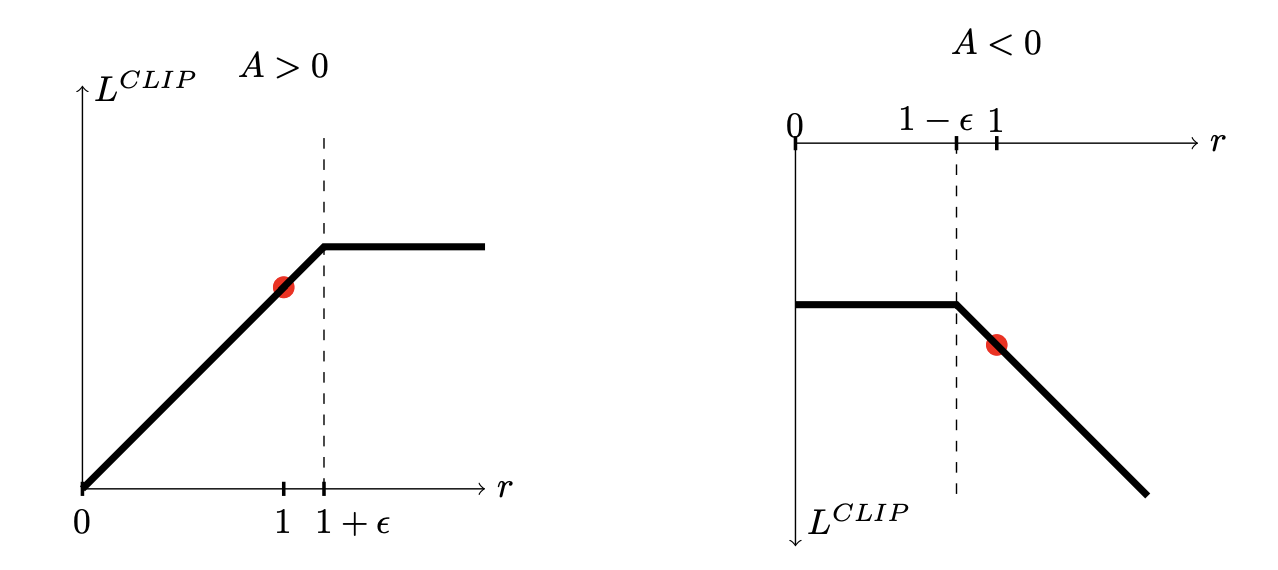

Image 1: Clipping in action based on the sign of the advantage function. Source [PPO Schulmann et al.](#ppo)

---

In the case of PPO being conservative with policy changes from $t \to t+1$, we choose the least of the clipped policy ratio and actual policy ratio which gurantees that we do not choose an action from a policy which is too eager thus reducing the risk of loss in the future. Although one thing that caught my eye after a few rounds of reading was that the objective here becomes to minimise the chance that we make a loss. I then discovered a [ESPO by Sun M. et al.](https://arxiv.org/pdf/2202.00079.pdf) which claims that PPO still cannot effectively bound the ratio. Here ESPO is performed without clipping the policy ratios but instead deciding on a stopping condition every epoch describing how to decide on this condition. Although intriguing, I did not manage to read or follow through they analysis due to limited time and the scope of this project.

---

#### Side note - Analogy

---

The way I understand the above approach, for the lack of a better analogy, looks related to the approach we take with regularization using $\lambda$ when dealing with linear regression models to solve bias-variance tradeoff and overfitting, where we instead penalise the weight update process to ensure we do not get greedy and over fit.

# References

Here is a list of core references that I refered in order to come up with the above summarization of the topics, mathematical formalization and code examples for verifying claims.

- <a id="ppo">[1]</a> [Proximal Policy Optimization, 2017, Schulman et al.](https://arxiv.org/pdf/1707.06347.pdf)
- <a id="openaidocs">[2]</a> [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/index.html)
- <a id="explinrl">[3]</a> [Exploration vs Exploitation](https://www.manifold.ai/exploration-vs-exploitation-in-reinforcement-learning)
- <a id="trpo">[4]</a> [Trust-Region Policy Optimization, 2017, Schulman et al.](https://arxiv.org/pdf/1502.05477.pdf)

---

# Reading List

Besides the core references I cited above, a great deal of my ideas were directly and strongly inspired by the following sources.

- [Introduction to RL by David Silver (DeepMIND) at UCL](https://youtube.com/playlist?list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-)
- [On vs Off Policy Learning](https://leimao.github.io/blog/RL-On-Policy-VS-Off-Policy/)
- [Lilian Wang's blog post on RL](https://lilianweng.github.io/posts/2018-02-19-rl-overview/#key-concepts)
- [Lilian Wang's blog post on Policy Gradient Algorithms](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/)
- [A crash course in PPO](https://www.neuralnet.ai/a-crash-course-in-proximal-policy-optimization/)
- [ESPO - A ratio clipping-less PPO](https://arxiv.org/pdf/2202.00079.pdf)

---